<a href="https://colab.research.google.com/github/pranukrish/CMPE256_AdvDataMining/blob/main/Assignment1/CMPE256_VARSilverGoldCommodityPricingPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CMPE 256 Class Presentation - VAR Commodity Pricing Model - Gold & Silver ###
###### Covers: Book Topics: Machine Learning and Artificial Intelligence for Agricultural Economics: Prognostic Data Analytics to Serve Small Scale Farmers Worldwide, Publisher :  Springer; 1st ed. 2021 edition (October 5, 2021), ISBN-13: 978-3030774844 ######

https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

***FORECASTING of Gold and Oil*** have garnered major attention from academics, investors and Government agencies like. These two products are known for their substantial influence on global economy. I will show here, how to use Granger’s Causality Test to test the relationships of multiple variables in the time series and Vector Auto Regressive Model (VAR) to forecast the future Gold & Oil prices from the historical data of ***Gold prices, Silver prices, Crude Oil prices, Stock index , Interest Rate and USD rate***.

https://www.lbma.org.uk/prices-and-data/precious-metal-prices#/
https://fred.stlouisfed.org/series/FEDFUNDS

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random 
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as spstats
import seaborn as sns


%matplotlib inline
mpl.style.reload_library()
mpl.style.use('classic')
mpl.rcParams['figure.facecolor'] = (1, 1, 1, 0)
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 40

In [2]:
! pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<H1> Gold Dataset </H1> <H3> Load Glod Dataset and set Date as Index. </H3>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Gold price data
goldDF = pd.read_csv("/content/drive/MyDrive/Data/DataSources-1/lbma_gold_am_usd_1967-12-31_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)
goldDF = goldDF.set_index('Date')
goldDF.head()


,GoldPrice
Date,
2022-03-31,1924.10
2022-03-30,1917.80
2022-03-29,1911.05
2022-03-28,1927.00
2022-03-25,1956.65


<h3> Check for nulls </H3>

In [5]:
goldDF.isnull().sum() ## missing values

GoldPrice    0
dtype: int64

In [6]:
goldDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13712 entries, 2022-03-31 to 1968-02-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GoldPrice  13712 non-null  float64
dtypes: float64(1)
memory usage: 214.2 KB


In [7]:
goldDF.columns

Index(['GoldPrice'], dtype='object')

Text(0, 0.5, 'Frequency')

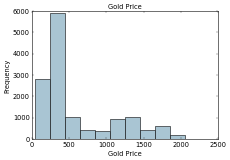

In [8]:
 
fig, ax = plt.subplots()
goldDF['GoldPrice'].hist(color='#A9C5D3', edgecolor='black',  
                          grid=False)
ax.set_title('Gold Price', fontsize=12)
ax.set_xlabel('Gold Price', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

<h5> Create Gold Price Bins - divide price into five quantiles (0, 25%, 50%, 75%, and 100%) </h5>

In [9]:
goldDF['GoldPrice_bin_round'] = np.array(np.floor(
                              np.array(goldDF['GoldPrice']) / 10.))
goldDF[['GoldPrice', 'GoldPrice_bin_round']].iloc[1071:2076]

,GoldPrice,GoldPrice_bin_round
Date,,
2018-08-01,1318.80,131.0
2018-05-01,1317.90,131.0
2018-04-01,1313.70,131.0
2018-03-01,1314.60,131.0
2018-02-01,1312.80,131.0
...,...,...
2014-01-23,1244.25,124.0
2014-01-22,1239.50,123.0
2014-01-21,1247.75,124.0


In [10]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = goldDF['GoldPrice'].quantile(quantile_list)
quantiles

0.00      34.780
0.25     281.775
0.50     384.000
0.75     892.250
1.00    2061.500
Name: GoldPrice, dtype: float64

Text(0, 0.5, 'Frequency')

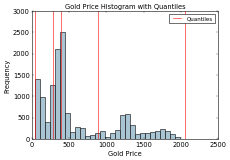

In [11]:
fig, ax = plt.subplots()
goldDF['GoldPrice'].hist(bins=30, color='#A9C5D3', 
                             edgecolor='black', grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Gold Price Histogram with Quantiles', 
             fontsize=12)
ax.set_xlabel('Gold Price', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [12]:
goldDF['GoldPrice_log'] = np.log((1+ goldDF['GoldPrice']))
goldDF[[ 'GoldPrice', 'GoldPrice_log']].iloc[4:9]

,GoldPrice,GoldPrice_log
Date,,
2022-03-25,1956.65,7.579500
2022-03-24,1945.90,7.573994
2022-03-23,1932.15,7.566906
2022-03-22,1929.35,7.565457
2022-03-21,1925.05,7.563227


Text(11.5, 450, '$\\mu$=5.96')

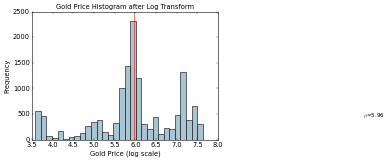

In [13]:
goldprice_log_mean = np.round(np.mean(goldDF['GoldPrice_log']), 2)
fig, ax = plt.subplots()
goldDF['GoldPrice_log'].hist(bins=30, color='#A9C5D3', 
                                 edgecolor='black', grid=False)
plt.axvline(goldprice_log_mean, color='r')
ax.set_title('Gold Price Histogram after Log Transform', 
             fontsize=12)
ax.set_xlabel('Gold Price (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(11.5, 450, r'$\mu$='+str(goldprice_log_mean), fontsize=10)

In [14]:
goldprice = np.array(goldDF['GoldPrice'])
goldprice_clean = goldprice[~np.isnan(goldprice)]
l, opt_lambda = spstats.boxcox(goldprice_clean)
print('Optimal lambda value:', opt_lambda)

Optimal lambda value: 0.22789603130062897


In [15]:
goldDF['goldprice_boxcox_lambda_0'] = spstats.boxcox(
                                        (1+goldDF['GoldPrice']), 
                                          lmbda=0)
goldDF['goldprice_boxcox_lambda_opt'] = spstats.boxcox(
                                            goldDF['GoldPrice'], 
                                              lmbda=opt_lambda)

goldDF[['GoldPrice', 'GoldPrice_log', 
               'goldprice_boxcox_lambda_0',       
               'goldprice_boxcox_lambda_opt']].iloc[4:9]

,GoldPrice,GoldPrice_log,goldprice_boxcox_lambda_0,goldprice_boxcox_lambda_opt
Date,,,,
2022-03-25,1956.65,7.579500,7.579500,20.294357
2022-03-24,1945.90,7.573994,7.573994,20.263387
2022-03-23,1932.15,7.566906,7.566906,20.223581
2022-03-22,1929.35,7.565457,7.565457,20.215448
2022-03-21,1925.05,7.563227,7.563227,20.202941


Text(24, 450, '$\\mu$=13.11')

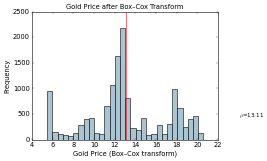

In [16]:
goldprice_boxcox_mean = np.round(
                      np.mean(
                       goldDF['goldprice_boxcox_lambda_opt']),2)
fig, ax = plt.subplots()
goldDF['goldprice_boxcox_lambda_opt'].hist(bins=30, 
                     color='#A9C5D3', edgecolor='black', grid=False)
plt.axvline(goldprice_boxcox_mean, color='r')
ax.set_title('Gold Price after Box–Cox Transform', 
             fontsize=12)
ax.set_xlabel('Gold Price (Box–Cox transform)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(24, 450, r'$\mu$='+str(goldprice_boxcox_mean), fontsize=10)

In [18]:
#Silver price data
silverDF = pd.read_csv("/content/drive/MyDrive/Data/DataSources-1/lbma_silver_am_usd_1967-12-31_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)
silverDF = silverDF.set_index('Date')
silverDF.head()


,SilverPrice
Date,
2022-03-31,24.815
2022-03-30,24.755
2022-03-29,24.640
2022-03-28,24.905
2022-03-25,25.620


In [19]:
silverDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13723 entries, 2022-03-31 to 1968-02-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SilverPrice  13704 non-null  float64
dtypes: float64(1)
memory usage: 214.4 KB


In [20]:
silverDF.isnull().sum() ## missing values

SilverPrice    19
dtype: int64

In [21]:
mean_imputation_silverDF = silverDF.copy()
mean_imputation_silverDF['SilverPrice_Mean_Filled'] = mean_imputation_silverDF['SilverPrice'].fillna(silverDF['SilverPrice'].mean())

In [22]:
silverDF.SilverPrice.describe().T

count    13704.000000
mean         9.852661
std          7.993719
min          1.272000
25%          4.615000
50%          5.985500
75%         14.820000
max         49.450000
Name: SilverPrice, dtype: float64

In [23]:
mean_imputation_silverDF.SilverPrice.describe().T

count    13704.000000
mean         9.852661
std          7.993719
min          1.272000
25%          4.615000
50%          5.985500
75%         14.820000
max         49.450000
Name: SilverPrice, dtype: float64

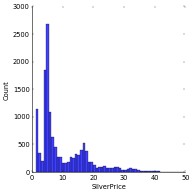

In [24]:
sns.displot(silverDF, x="SilverPrice")

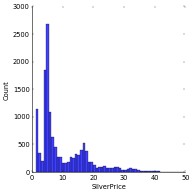

In [25]:
sns.displot(mean_imputation_silverDF, x="SilverPrice")

In [26]:
silverDF['SilverPrice_log'] = np.log((1+ silverDF['SilverPrice']))
silverDF[[ 'SilverPrice', 'SilverPrice_log']].iloc[4:9]

,SilverPrice,SilverPrice_log
Date,,
2022-03-25,25.620,3.281663
2022-03-24,25.315,3.270139
2022-03-23,25.015,3.258673
2022-03-22,25.085,3.261360
2022-03-21,25.035,3.259442


Text(11.5, 450, '$\\mu$=2.15')

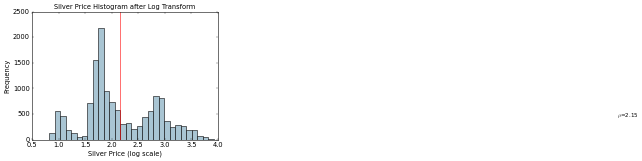

In [27]:

silverprice_log_mean = np.round(np.mean(silverDF['SilverPrice_log']), 2)
fig, ax = plt.subplots()
silverDF['SilverPrice_log'].hist(bins=30, color='#A9C5D3', 
                                 edgecolor='black', grid=False)
plt.axvline(silverprice_log_mean, color='r')
ax.set_title('Silver Price Histogram after Log Transform', 
             fontsize=12)
ax.set_xlabel('Silver Price (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(11.5, 450, r'$\mu$='+str(silverprice_log_mean), fontsize=10)

In [28]:
! pip install impyute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
# silverDF

In [32]:
# USD Index
# Trade Weighted U.S. Dollar Index: Broad, Goods and Services (DTWEXBGS)
# https://fred.stlouisfed.org/series/DTWEXBGS 
usdFedFundsDF = pd.read_csv("/content/drive/MyDrive/Data/DataSources-1/FEDFUNDS_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)


usdFedFundsDF = usdFedFundsDF.set_index('Date')

usdFedFundsDF.head() 

,FEDFUNDS
Date,
1954-01-07,0.80
1954-01-08,1.22
1954-01-09,1.07
1954-01-10,0.85
1954-01-11,0.83


In [33]:
usdFedFundsDF.tail(10)

,FEDFUNDS
Date,
2021-01-06,0.08
2021-01-07,0.10
2021-01-08,0.09
2021-01-09,0.08
2021-01-10,0.08
2021-01-11,0.08
2021-01-12,0.08
2022-01-01,0.08
2022-01-02,0.08


In [34]:
usdFedFundsDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 813 entries, 1954-01-07 to 2022-01-03
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FEDFUNDS  813 non-null    float64
dtypes: float64(1)
memory usage: 12.7 KB


In [35]:
usdFedFundsDF.isnull().sum() ## missing values

FEDFUNDS    0
dtype: int64

In [38]:
# Interest
# 10-Year Treasury Constant Maturity Rate (DGS10)
# https://fred.stlouisfed.org/series/DGS10

### https://fred.stlouisfed.org/series/FEDFUNDS
interestRateDF = pd.read_csv("/content/drive/MyDrive/Data/DataSources-1/DGS10.csv",parse_dates=['DATE'], dayfirst=True)
interestRateDF = interestRateDF.rename(columns={"DATE":'Date'})

interestRateDF = interestRateDF.set_index('Date')

interestRateDF.head() 

,DGS10
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


In [39]:
interestRateDF.tail(10)

,DGS10
Date,
2022-04-06,2.61
2022-04-07,2.66
2022-04-08,2.72
2022-04-11,2.79
2022-04-12,2.72
2022-04-13,2.70
2022-04-14,2.83
2022-04-15,.
2022-04-18,2.85


In [40]:
interestRateDF['DGS10'] = interestRateDF['DGS10'].replace('.',np.nan)

In [41]:
interestRateDF.isnull().sum() ## missing values

DGS10    671
dtype: int64

In [42]:
interestRateDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15731 entries, 1962-01-02 to 2022-04-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DGS10   15060 non-null  object
dtypes: object(1)
memory usage: 245.8+ KB


In [43]:
interestRateDF.isnull().sum() ## missing values

DGS10    671
dtype: int64

In [44]:
# S&P Index
# https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1611360000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
# https://finance.yahoo.com/quote/%5EGSPC/history?period1=-628819200&period2=1650412800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
spindex500Index = pd.read_csv("/content/drive/MyDrive/Data/DataSources-1/SPIndex_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)

spindex500Index = spindex500Index.set_index('Date')

spindex500Index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14100 entries, 2022-04-19 to 2066-04-14
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Open         14100 non-null  object
 1   High         14100 non-null  object
 2   Low          14100 non-null  object
 3   Close*       14100 non-null  object
 4   Adj Close**  14100 non-null  object
 5   Volume       14100 non-null  object
dtypes: object(6)
memory usage: 771.1+ KB


In [45]:
spindex500Index.isnull().sum() ## missing values

Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64

In [46]:
spindex500Index.columns

Index(['Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume'], dtype='object')

In [47]:

spindex500Index = spindex500Index.drop('Open', 1)
spindex500Index = spindex500Index.drop('High', 1)
spindex500Index = spindex500Index.drop('Low', 1)
spindex500Index = spindex500Index.drop('Close*', 1)
spindex500Index = spindex500Index.drop('Volume', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipyker

In [48]:



spindex500Index= spindex500Index.rename(columns={'Adj Close**':'AdjClose'})


In [49]:
spindex500Index['AdjClose'] = spindex500Index['AdjClose'].replace(',', '')

In [50]:
spindex500Index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14100 entries, 2022-04-19 to 2066-04-14
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AdjClose  14100 non-null  object
dtypes: object(1)
memory usage: 220.3+ KB


In [51]:
#spindex500Index

In [52]:
spindex500Index=spindex500Index.loc['19720101':'20220419']
#spindex500Index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.


In [54]:
# Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma
# https://fred.stlouisfed.org/series/DCOILWTICO
oilPricesDF = pd.read_csv("/content/drive/MyDrive/Data/DataSources-1/DCOILWTICO_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)
oilPricesDF = oilPricesDF.set_index('Date')
oilPricesDF.head()

,CrudeOilPrices(WTI)
Date,
1986-02-01,25.56
1986-03-01,26
1986-06-01,26.53
1986-07-01,25.85
1986-08-01,25.87


In [55]:
oilPricesDF['CrudeOilPrices(WTI)'] = oilPricesDF['CrudeOilPrices(WTI)'].replace('.',np.nan)

In [56]:
oilPricesDF.isnull().sum() ## missing values

CrudeOilPrices(WTI)    323
dtype: int64

In [57]:
oilPricesDF['CrudeOilPrices(WTI)']

Date
1986-02-01     25.56
1986-03-01        26
1986-06-01     26.53
1986-07-01     25.85
1986-08-01     25.87
               ...  
2022-12-04    100.52
2022-04-13    104.26
2022-04-14    106.84
2022-04-15       NaN
2022-04-18    108.24
Name: CrudeOilPrices(WTI), Length: 9468, dtype: object

### Exploratory analysis: ###

Let’s load the data and do some analysis with visualization to know insights of the data. Exploratory data analysis is quite extensive in multivariate time series. I will cover some areas here to get insights of the data. However, it is advisable to conduct all statistical tests to ensure our clear understanding on data distribution.

In [58]:
oilPricesDF.columns
### https://stackoverflow.com/questions/46834732/convert-pandas-datetime-column-yyyy-mm-dd-to-yyyymmdd
## https://datatofish.com/strings-to-datetime-pandas/

Index(['CrudeOilPrices(WTI)'], dtype='object')

In [59]:

pd.set_option('display.max_rows', None)
dataset = pd.concat([goldDF,silverDF,oilPricesDF,usdFedFundsDF,interestRateDF,spindex500Index], axis=1)
print('Number of colums in Dataframe : ', len(dataset.columns))
print('Number of rows in Dataframe : ', len(dataset.index))
print(dataset)

Number of colums in Dataframe :  11
Number of rows in Dataframe :  17460


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [60]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17460 entries, 1954-01-07 to 2022-12-04
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   GoldPrice                    13712 non-null  float64
 1   GoldPrice_bin_round          13712 non-null  float64
 2   GoldPrice_log                13712 non-null  float64
 3   goldprice_boxcox_lambda_0    13712 non-null  float64
 4   goldprice_boxcox_lambda_opt  13712 non-null  float64
 5   SilverPrice                  13704 non-null  float64
 6   SilverPrice_log              13704 non-null  float64
 7   CrudeOilPrices(WTI)          9145 non-null   object 
 8   FEDFUNDS                     813 non-null    float64
 9   DGS10                        15060 non-null  object 
 10  AdjClose                     12685 non-null  object 
dtypes: float64(8), object(3)
memory usage: 1.6+ MB


In [61]:
dataset.drop(['GoldPrice_bin_round','GoldPrice_log','goldprice_boxcox_lambda_0','goldprice_boxcox_lambda_opt','SilverPrice_log'], axis = 1, inplace = True, errors = 'ignore')

***Let’s fix the dates for all the series.***

In [62]:
# dataset

In [63]:
dataset.tail()

,GoldPrice,SilverPrice,CrudeOilPrices(WTI),FEDFUNDS,DGS10,AdjClose
Date,,,,,,
2022-11-02,1826.25,22.895,93.1,NaN,NaN,NaN
2022-11-03,1991.45,25.655,109.31,NaN,NaN,NaN
2022-11-04,NaN,NaN,94.22,NaN,NaN,NaN
2022-12-01,1816.40,22.745,82.51,NaN,NaN,NaN
2022-12-04,NaN,NaN,100.52,NaN,NaN,NaN


In [64]:
### dataset=dataset.loc['20100101':'20200824']
dataset=dataset.loc['20000101':'20220301']
dataset.head()

,GoldPrice,SilverPrice,CrudeOilPrices(WTI),FEDFUNDS,DGS10,AdjClose
Date,,,,,,
2000-01-01,NaN,NaN,NaN,5.45,NaN,NaN
2000-01-02,283.65,5.243,28.28,5.73,NaN,NaN
2000-01-03,293.75,5.125,31.71,5.85,6.58,"1,455.22"
2000-01-04,NaN,NaN,NaN,6.02,6.49,"1,399.42"
2000-01-05,NaN,NaN,25.84,6.27,6.62,"1,402.11"


In [65]:
dataset.tail()

,GoldPrice,SilverPrice,CrudeOilPrices(WTI),FEDFUNDS,DGS10,AdjClose
Date,,,,,,
2022-02-23,1895.70,24.105,92.14,NaN,1.99,"4,225.50"
2022-02-24,1968.35,25.315,92.77,NaN,1.96,"4,288.70"
2022-02-25,1912.15,24.210,91.68,NaN,1.97,"4,384.65"
2022-02-28,1903.30,24.350,96.13,NaN,1.83,"4,373.94"
2022-03-01,NaN,NaN,75.99,NaN,1.72,"4,306.26"


In [66]:
dataset.isnull().sum() ## missing values

GoldPrice               848
SilverPrice             848
CrudeOilPrices(WTI)     887
FEDFUNDS               6170
DGS10                   893
AdjClose                861
dtype: int64

In [67]:
# https://stackoverflow.com/questions/31170550/pandas-df-fillnamethod-pad-not-working-on-28000-row-df

dataset=dataset.fillna(method='pad') 
dataset = dataset.fillna(method = 'bfill')

In [68]:
dataset.isnull().sum() ## missing values

GoldPrice              0
SilverPrice            0
CrudeOilPrices(WTI)    0
FEDFUNDS               0
DGS10                  0
AdjClose               0
dtype: int64

In [104]:
dataset=dataset.dropna()
dataset.head()

,GoldPrice,SilverPrice,CrudeOilPrices(WTI),FEDFUNDS,DGS10,AdjClose
Date,,,,,,
2000-01-01,283.65,5.243,28.28,5.45,6.58,1455.22
2000-01-02,283.65,5.243,28.28,5.73,6.58,1455.22
2000-01-03,293.75,5.125,31.71,5.85,6.58,1455.22
2000-01-04,293.75,5.125,31.71,6.02,6.49,1399.42
2000-01-05,293.75,5.125,25.84,6.27,6.62,1402.11


In [70]:
#print(dataset)

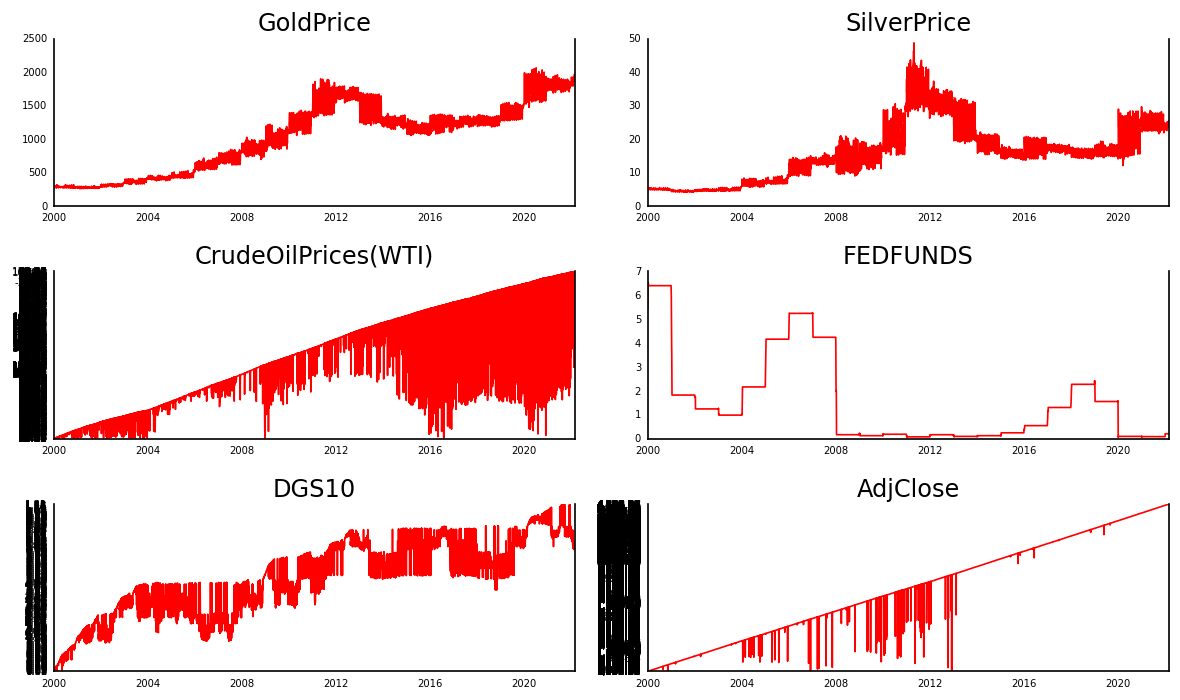

In [71]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
 data = dataset[dataset.columns[i]]
 ax.plot(data, color='red', linewidth=1)
 ax.set_title(dataset.columns[i])
 ax.xaxis.set_ticks_position('none')
 ax.yaxis.set_ticks_position('none')
 ax.spines["top"].set_alpha(0)
 ax.tick_params(labelsize=6)
plt.tight_layout();

***From the above plots, we can visible conclude that, all the series contain unit root with stochastic trend showing a systematic pattern that is unpredictable.***

### Normality Test ###
To extract maximum information from our data, it is important to have a ***normal or Gaussian distribution*** of the data. 
To check for that, we have done a normality test based on the Null and Alternate Hypothesis intuition.


In [101]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6437 entries, 2000-01-01 to 2022-03-01
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GoldPrice            6437 non-null   float64
 1   SilverPrice          6437 non-null   float64
 2   CrudeOilPrices(WTI)  6437 non-null   float64
 3   FEDFUNDS             6437 non-null   float64
 4   DGS10                6437 non-null   float64
 5   AdjClose             6437 non-null   float64
dtypes: float64(6)
memory usage: 352.0 KB


In [102]:
itemcost='1,455.22'
itemcostProc=itemcost.replace(',','')
print(itemcostProc)
print(float(itemcostProc))

1455.22
1455.22


In [ ]:
dataset['AdjClose']= dataset['AdjClose'].apply(lambda x: x.replace(',',''))

In [ ]:
dataset['AdjClose']

In [ ]:
dataset['CrudeOilPrices(WTI)'] = dataset['CrudeOilPrices(WTI)'].astype('float64')
dataset['CrudeOilPrices(WTI)'] = dataset['CrudeOilPrices(WTI)'].astype('float64')
dataset['DGS10'] = dataset['DGS10'].astype('float64')
dataset['AdjClose'] = dataset['AdjClose'].astype('float64')
dataset.dtypes

In [ ]:
dataset['CrudeOilPrices(WTI)']

In [ ]:
from scipy import stats

GoldPrice=dataset.GoldPrice.values
print(GoldPrice)


stat,p = stats.normaltest(GoldPrice)

print("GoldPrice Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')


In [ ]:
from scipy import stats

SilverPrice=dataset.SilverPrice.values
print(SilverPrice)


stat,p = stats.normaltest(SilverPrice)

print("SilverPrice Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')


In [ ]:
from scipy import stats

OilPrice=dataset['CrudeOilPrices(WTI)'].values
print(OilPrice)


stat,p = stats.normaltest(OilPrice)

print("OilPrice Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

In [ ]:
from scipy import stats

FEDFUNDS=dataset.FEDFUNDS.values
print(FEDFUNDS)


stat,p = stats.normaltest(FEDFUNDS)

print("FEDFUNDS Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

In [ ]:
from scipy import stats

InterestRate=dataset.DGS10.values
print(InterestRate)


stat,p = stats.normaltest(InterestRate)

print("InterestRate Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

In [ ]:
dataset.describe()

In [ ]:
weekly_data = dataset.resample('W').mean()

In [ ]:
#weekly_data

In [ ]:
monthly_data = dataset.resample('M').mean()

In [ ]:
#monthly_data

In [ ]:
# Plot
# Takes long time 
# fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
# for i, ax in enumerate(axes.flatten()):
#  data = monthly_data[monthly_data.columns[i]]
#  ax.plot(data, color='red', linewidth=1)
#  ax.set_title(monthly_data.columns[i])
#  ax.xaxis.set_ticks_position('none')
#  ax.yaxis.set_ticks_position('none')
#  ax.spines["top"].set_alpha(0)
#  ax.tick_params(labelsize=6)
# plt.tight_layout();

In [ ]:
yearly_data = dataset.resample('Y').mean()

In [ ]:
yearly_data

In [ ]:
# Plot
# Takes long time 
# fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
# for i, ax in enumerate(axes.flatten()):
#  data = yearly_data[yearly_data.columns[i]]
#  ax.plot(data, color='red', linewidth=1)
#  ax.set_title(yearly_data.columns[i])
#  ax.xaxis.set_ticks_position('none')
#  ax.yaxis.set_ticks_position('none')
#  ax.spines["top"].set_alpha(0)
#  ax.tick_params(labelsize=6)
# plt.tight_layout();

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset.GoldPrice.plot(kind = 'density')  

print('Gold: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset.GoldPrice)))
print('Gold:Skewness of normal distribution: {}'.format(stats.skew(dataset.GoldPrice)))

These two distributions give us some intuition about the distribution of our data. The kurtosis of this dataset is -0.18. Since this value is less than 0, it is considered to be a light-tailed dataset. It has as much data in each tail as it does in the peak. Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset.SilverPrice.plot(kind = 'density') 

print('Silver: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset.SilverPrice)))
print('Silver:Skewness of normal distribution: {}'.format(stats.skew(dataset.SilverPrice)))

These two distributions give us some intuition about the distribution of our data. The kurtosis of this dataset is -0.95. Since this value is less than 0, it is considered to be a light-tailed dataset. It has as much data in each tail as it does in the peak. Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset['CrudeOilPrices(WTI)'].plot(kind = 'density') 

print('Oil: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset['CrudeOilPrices(WTI)'])))
print('Oil:Skewness of normal distribution: {}'.format(stats.skew(dataset['CrudeOilPrices(WTI)'])))

These two distributions give us some intuition about the distribution of our data. The kurtosis of this dataset is -1.16. Since this value is less than 0, it is considered to be a light-tailed dataset. It has as much data in each tail as it does in the peak. Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset.FEDFUNDS.plot(kind = 'density') 

print('FEDFUNDS: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset.FEDFUNDS)))
print('FEDFUNDS:Skewness of normal distribution: {}'.format(stats.skew(dataset.FEDFUNDS)))

These two distributions give us some intuition about the distribution of our data. The kurtosis of this dataset is -1.43. Since this value is less than 0, it is considered to be a light-tailed dataset. It has as much data in each tail as it does in the peak. Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
dataset['GoldPrice'].hist(bins=50)
plt.title('Gold')
plt.subplot(1,2,2)
stats.probplot(dataset['GoldPrice'], plot=plt);
dataset.GoldPrice.describe().T

Normal probability plot also shows the data is far from normally distributed.

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
dataset['SilverPrice'].hist(bins=50)
plt.title('Silver')
plt.subplot(1,2,2)
stats.probplot(dataset['SilverPrice'], plot=plt);
dataset.SilverPrice.describe().T

Normal probability plot also shows the data is far from normally distributed.

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
corr = dataset.corr()

fig, ax = plt.subplots()
sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
dataset.info()

In [ ]:
#dataset

### Auto-correlation ###

###### Auto-correlation or serial correlation can be a significant problem in analyzing historical data if we do not know how to look out for it. #######

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# plots the autocorrelation plots for each stock's price at 50 lags
for i in dataset:
    series = dataset[i]
    sm.graphics.tsa.plot_acf(series)
    plt.title('ACF for %s' % i)
    plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# plots the autocorrelation plots for each stock's price at 50 lags
for i in dataset:
    sm.graphics.tsa.plot_acf(dataset[i], lags = 50)
    plt.title('ACF for %s' % i)
plt.show()

We see here from the above plots, the auto-correlation of +1 which represents a perfect positive correlation which means, an increase seen in one time series leads to a proportionate increase in the other time series. We definitely need to apply transformation and neutralize this to make the series stationary. It measures linear relationships; even if the auto-correlation is minuscule, there may still be a nonlinear relationship between a time series and a lagged version of itself.

In [ ]:
dataset.info()

In [ ]:
dataset['AdjClose']

### Train and Test Data: ###
The VAR model will be fitted on X_train and then used to forecast the next 15 observations. These forecasts will be compared against the actual present in test data.

In [ ]:
n_obs=15
X_train, X_test = dataset[0:-n_obs], dataset[-n_obs:]
print(X_train.shape, X_test.shape) 

### Transformation: ###

Applying first differencing on training set to make all the series stationary. However, this is an iterative process where we after first differencing, the series may still be non-stationary. We shall have to apply second difference or log transformation to standardize the series in such cases.

In [ ]:
transform_data = X_train.diff().dropna()
transform_data.head()


In [ ]:
transform_data.describe()

### Stationarity check ###


In [ ]:
!pip install statsmodels 

In [ ]:
import statsmodels.tsa.stattools as sm
def augmented_dickey_fuller_statistics(time_series):
    result = sm.adfuller(time_series.values, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [ ]:
print('Augmented Dickey-Fuller Test: Gold Price Time Series')
augmented_dickey_fuller_statistics(transform_data['GoldPrice'])
print('Augmented Dickey-Fuller Test: Silver Price Time Series')
augmented_dickey_fuller_statistics(transform_data['SilverPrice'])
print('Augmented Dickey-Fuller Test: CrudeOilPrices(WTI)  Time Series')
augmented_dickey_fuller_statistics(transform_data['CrudeOilPrices(WTI)'])
print('Augmented Dickey-Fuller Test: FEDFUNDS Time Series')
augmented_dickey_fuller_statistics(transform_data['FEDFUNDS'])
print('Augmented Dickey-Fuller Test: DGS10 Time Series')
augmented_dickey_fuller_statistics(transform_data['DGS10'])
print('Augmented Dickey-Fuller Test: AdjClose Time Series')
augmented_dickey_fuller_statistics(transform_data['AdjClose'])

##GoldPrice	SilverPrice	CrudeOilPrices(WTI)	FEDFUNDS	DGS10	AdjClose


In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    d = transform_data[transform_data.columns[i]]
    ax.plot(d, color='red', linewidth=1)
    # Decorations
    ax.set_title(dataset.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Granger’s Causality Test: ###


The formal definition of Granger causality can be explained as, whether past values of x aid in the prediction of yt, conditional on having already accounted for the effects on yt of past values of y (and perhaps of past values of other variables). If they do, the x is said to “Granger cause” y. So, the basis behind VAR is that each of the time series in the system influences each other.
Granger’s causality Tests the null hypothesis that the coefficients of past values in the regression equation is zero. So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis. This has been performed on original data-set.

In [ ]:
import statsmodels.tsa.stattools as sm
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = sm.grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset



In [ ]:
grangers_causality_matrix(dataset, variables = dataset.columns)
## https://rishi-a.github.io/2020/05/25/granger-causality.html
## https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

The row are the response (y) and the columns are the predictor series (x).
* If we take the value 0.0000 in (row 1, column 5), it refers to the p-value of the Granger’s Causality test for InterestRate_x causing Gold_y. The 0.0000 in (row 5, column 1) refers to the p-value of InterestRate_y causing GoldPrice_x and so on.
* We can see that, in the case of Interest and USD variables, we cannot reject null hypothesis e.g. USD & Silver, USD & Oil. 
* Our variables of interest are Gold and Oil here. So, for Gold, all the variables cause but for USD doesn’t causes any effect on Oil.

So, looking at the p-Values, we can assume that, except USD, all the other variables (time series) in the system are interchangeably causing each other. This justifies the VAR modeling approach for this system of multi time-series to forecast.

### VAR model ###

VAR requires stationarity of the series which means the mean to the series do not change over time (we can find this out from the plot drawn next to Augmented Dickey-Fuller Test).


So, I will fit the VAR model on training set and then used the fitted model to forecast the next 15 observations. These forecasts will be compared against the actual present in test data. I have taken the maximum lag (15) to identify the required lags for VAR model.

In [ ]:
import numpy as np
import pandas
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

mod = VAR(transform_data)
res = mod.fit(maxlags=15, ic='aic')
print(res.summary())

### Residual plot ###

Residual plot looks normal with constant mean throughout apart from some large fluctuation during 2009, 2011, 2014 etc.

In [ ]:
y_fitted = res.fittedvalues
y_fitted

In [ ]:
y_fitted = res.fittedvalues
residuals = res.resid
plt.figure(figsize = (15,5))
plt.plot(residuals, label='resid')
plt.plot(y_fitted, label='VAR prediction')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Residuals')
plt.grid(True)

### Durbin-Watson Statistic ###
The Durbin-Watson statistic will always have a value between 0 and 4. A value of 2.0 means that there is no auto-correlation detected in the sample. Values from 0 to less than 2 indicate positive auto-correlation and values from 2 to 4 indicate negative auto-correlation. A rule of thumb is that test statistic values in the range of 1.5 to 2.5 are relatively normal. Any value outside this range could be a cause for concern.

###### A stock price displaying positive auto-correlation would indicate that the price yesterday has a positive correlation on the price today — so if the stock fell yesterday, it is also likely that it falls today. A stock that has a negative auto-correlation, on the other hand, has a negative influence on itself over time — so that if it fell yesterday, there is a greater likelihood it will rise today. ######

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(res.resid)
for col,val in zip(transform_data.columns, out):
    print((col), ":", round(val,2))
    

#### There is no auto-correlation (2.0) exist; so, we can proceed with the forecast. ####

#### Prediction: #### 
In order to forecast, the VAR model expects up to the lag order number of observations from the past data. This is because, the terms in the VAR model are essentially the lags of the various time series in the data-set, so we need to provide as many of the previous values as indicated by the lag order used by the model.

In [ ]:
# Get the lag order
lag_order = res.k_ar
print(lag_order)
# Input data for forecasting
input_data = transform_data.values[-lag_order:]
print(input_data)
# forecasting
pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print(pred)

In [ ]:
print(X_test.index)

#### Invert the transformation: ####

The forecasts are generated but it is on the scale of the training data used by the model. So, to bring it back up to its original scale, we need to de-difference it.
The way to convert the differencing is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number.
This process can be reversed by adding the observation at the prior time step to the difference value. inverted(ts) = differenced(ts) + observation(ts-1)

In [ ]:
# inverting transformation
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
        return forecast

output = invert_transformation(X_train, pred)

## https://stackoverflow.com/questions/20461165/how-to-convert-index-of-a-pandas-dataframe-into-a-column
output['Date'] = output.index

print(output)

In [ ]:
output.columns

In [ ]:
output.info()

In [ ]:
print(output['GoldPrice_pred'])

In [ ]:
output

In [ ]:
#combining predicted and real data set
combine = pd.concat([output['GoldPrice_pred'], X_test['GoldPrice']], axis=1)
combine['accuracy'] = round(combine.apply(lambda row: row.GoldPrice_pred /row.GoldPrice *100, axis = 1),2)
combine['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine['accuracy']],index = combine.index)
combine = combine.round(decimals=2)
combine = combine.reset_index()
combine = combine.sort_values(by='Date', ascending=False)

print(combine)

In [ ]:
# old
#combining predicted and real data set
combine = pd.concat([output['GoldPrice_pred'], X_test['GoldPrice']], axis=1)
combine['accuracy'] = round(combine.apply(lambda row: row.GoldPrice_pred /row.GoldPrice *100, axis = 1),2)
combine['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine['accuracy']],index = combine.index)
combine = combine.round(decimals=2)
combine = combine.reset_index()
combine = combine.sort_values(by='Date', ascending=False)

print(combine)

#### Evaluation: #### 
To evaluate the forecasts, a comprehensive set of metrics, such as the MAPE, ME, MAE, MPE and RMSE can be computed. We have computed some of these as below.

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
#Forecast bias
forecast_errors = [combine['GoldPrice'][i]- combine['GoldPrice_pred'][i] for i in range(len(combine['GoldPrice']))]
bias = sum(forecast_errors) * 1.0/len(combine['GoldPrice'])

print('Bias: %f' % bias) 
print('Mean absolute error:', mean_absolute_error(combine['GoldPrice'].values, combine['GoldPrice_pred'].values))
print('Mean squared error:', mean_squared_error(combine['GoldPrice'].values, combine['GoldPrice_pred'].values))
print('Root mean squared error:', math.sqrt(mean_squared_error(combine['GoldPrice'].values, combine['GoldPrice_pred'].values)))

In [ ]:
## https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

fig, axes = plt.subplots(nrows=int(len(dataset.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(dataset.columns, axes.flatten())):
    output[col+'_pred'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    X_test[col][-n_obs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#### Summary #### 

The VAR model is a popular tool for the purpose of predicting joint dynamics of multiple time series based on linear functions of past observations. More analysis e.g. impulse response (IRF) and forecast error variance decomposition (FEVD) can also be done along-with VAR to for assessing the impacts of shock from one asset on another to assess the impacts of shock from one asset on another. However, I will keep this simple here for easy understanding. In real-life business case, we should do multiple models with different approach to do the comparative analysis before zeroed down on one or a hybrid model.


### Prophet In Action ###

In [ ]:
# Time Series
# https://dev.socrata.com/blog/2019/10/07/time-series-analysis-with-jupyter-notebooks-and-socrata.html

# Data Source
# Building Permits
# https://data.seattle.gov/Permitting/Building-Permits/76t5-zqzr

dataset.info()
df3=dataset

In [ ]:
dataset.index

In [ ]:
from fbprophet import Prophet
model = Prophet()
train_df = df3.rename(columns={"GoldPrice":'y'})
train_df["ds"] = train_df.index
model.fit(train_df)

In [ ]:
pd.plotting.register_matplotlib_converters()

# We want to forecast over the next 5 months
future = model.make_future_dataframe(30, freq='D', include_history=True)
forecast = model.predict(future)
model.plot(forecast)

In [ ]:
forecast